In [1]:
import torch
from utils.config import ModelConfig
from models.unet import UNetWithCrossAttention
from models.diffusion import Diffusion
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from utils.SoundDataset import SoundDataset
from torch.utils.data import DataLoader

In [2]:
def load_snapshot(snapshot_path, raw_model):
    snapshot = torch.load(snapshot_path)
    raw_model.load_state_dict(snapshot["MODEL_STATE"])
    train_losses = snapshot["TRAIN_LOSSES"]
    val_losses = snapshot["VAL_LOSSES"]

    return raw_model, train_losses, val_losses

In [3]:
image_path = "data/images"
sound_path = "data/sounds"

data = SoundDataset(image_path, sound_path)

val_loader = DataLoader(data, 
                        batch_size=8,
                        pin_memory=True,
                        shuffle=False, 
                        drop_last=True)

In [4]:
# from archisound import ArchiSound

device = "cuda" if torch.cuda.is_available() else "cpu"

# autoencoder = ArchiSound.from_pretrained("dmae1d-ATC64-v2").to(device)

from models.AudioEncoder import AudioEncoder

encode = AudioEncoder("facebook/wav2vec2-base-960h",
                                    device,
                                    48000)

/home/usr/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
config = ModelConfig({"image_size": 128, "audio_ctx_dim": 768})

# Инициализация
diffusion = Diffusion(timesteps=1000, image_size=128, device=device)
model = UNetWithCrossAttention(config)

In [6]:
model, train_losses, val_losses = load_snapshot("result.pt", model)

/tmp/ipykernel_6131/2394094483.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  snapshot = torch.load(snapshot_path)


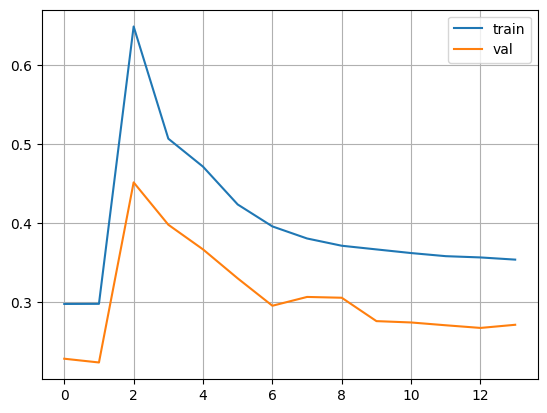

In [12]:
plt.plot(train_losses[32:], label='train')
plt.plot(val_losses[32:], label='val')
plt.grid()
plt.legend()

In [8]:
audio,image = next(iter(val_loader))
audio_embeds = encode(audio.to(device))

model.to(device)
model.eval()
generated_image = diffusion.reverse_process(
    model,
    audio_embeds,
    guidance_scale=7.5,
    batch_size=8,
    use_ddim=True,
    timesteps=100  #число шагов
)

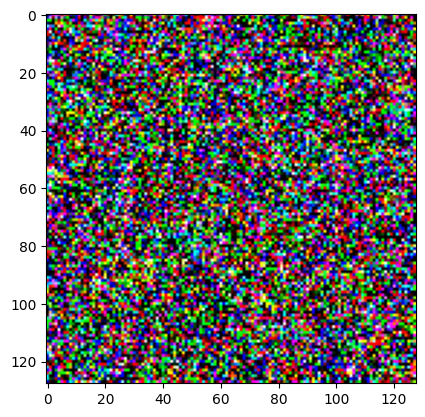

In [9]:
plt.imshow(torch.permute(generated_image[0].cpu(), (1,2,0)).numpy())

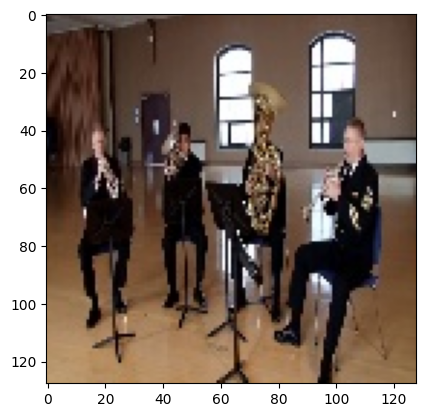

In [10]:
plt.imshow(torch.permute(image[0], (1,2,0)))

In [11]:
# модель сошлась на lr=0.0005 на 30 эпохах. Потери составили ~0.68
# размерность UNet:
# DownBlock(3, 32, 0.3),
# DownBlock(32, 64, 0.3),
# DownBlock(64, 128, 0.3),
# DownBlock(128, 256, 0.3)

# попробуем увеличить размер UNet в 2 раза:
# результатом стали точно такие же потери.
# Изменили финальную функцию активации на Tanh:
# на 16 эпохах получили потери 0.31
# на 32 эпохах потери составили чуть меньше 0.30 

# заменим все функции активации на tanh и повторим эксперимент
# экспиримент провалился, потери составили 0.35

# необходимо провести значительную отимизацию всего сценария обучения:
#   1. Вычислить эмбединги всех звуковых файлов и сфоримровать на их основе новый датасет
#   2. На основе более быстрого сценария провести обучение на большом числе эпох ~100